In [1]:
import sys, os, time, shutil
from IPython.core.display import display, HTML
# display(HTML("<style>.container { width:98% !important; }</style>"))
os.environ['FOUNDATION_RUN_MODE'] = 'jupyter'
os.environ['FOUNDATION_SAVE_DIR'] = r'D:\completed'
os.environ['FOUNDATION_DATA_DIR'] = r'D:\local_data'
# %load_ext autoreload
# %autoreload 2
# %pdb
from tqdm import tqdm_notebook as tqdm
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.distributions as distrib
import torch.multiprocessing as mp
import torchvision.models
from torch.utils.data import Dataset, DataLoader, TensorDataset

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.preprocessing import normalize

import gym
import inspect
import numpy as np
import pickle

#%matplotlib tk
import matplotlib.pyplot as plt
#plt.switch_backend('Qt5Agg') #('Qt5Agg')
import foundation as fd
from foundation import models
from foundation import util
from foundation import train as trn
#from foundation.util import replicate, Cloner

import matplotlib.patches as mpatches
import matplotlib.pyplot as plt
import matplotlib.cm
from matplotlib import animation
import matplotlib as mpl
from matplotlib import cm
# mpl.rc('image', cmap='gray')

# import gpumap
# import umap, shap
# import umap.plot
from adjustText import adjust_text

from matplotlib.patches import Patch
from matplotlib.lines import Line2D

from sklearn.decomposition import PCA
import sklearn.datasets

# import gpumap

%matplotlib notebook

import visualizations as viz_util
import project as proj
# import pointnets as ptn

np.set_printoptions(linewidth=120)

In [2]:
%matplotlib notebook

In [3]:
root = os.environ['FOUNDATION_SAVE_DIR']
results_name = 'final'

In [4]:
def organize(raw, runs=None, **common):
    raw = raw.split('\n')
    if runs is None:
        runs = util.Table()
    for line in raw:
        n,d,t,s1,s2,s3 = line.split('\t')
        run = runs.new(name=n, dataset=d, arch=t, 
                 stage1=s1, stage2=s2, stage3=s3, 
                 **common)
        if len(run.stage1) < 10:
            run.stage1 = None
        if len(run.stage2) < 10:
            run.stage2 = None
        if len(run.stage3) < 10:
            run.stage3 = None
    return runs


def save_fig(name):
    plt.savefig(f'figures/{name}.png')
    plt.savefig(f'figures/{name}.pdf')
    print(name, 'saved')

# fixed_names = {
#     '12 Branch': '12-SAE',
#     '6 Branch': '6-SAE',
#     '4 Branch': '4-SAE',
    
#     '12 Head': '12-ASAE',
#     '6 Head': '6-ASAE',
#     '4 Head': '4-ASAE',
    
#     'LVAE 12': '12-VLAE',
#     'LVAE 6': '6-VLAE',
#     'LVAE 4': '4-VLAE',
    
#     'beta-VAE': r'$\beta$VAE',
# }

fixed_names = {
    '12 Branch': 'K12',
    '6 Branch': 'K6',
    '4 Branch': 'K4',
    
    '12 Head': 'H12',
    '6 Head': 'H6',
    '4 Head': 'H4',
    
    '12 LVAE': 'L12',
    '6 LVAE': 'L6',
    '4 LVAE': 'L4',
    'LVAE 12': 'L12',
    'LVAE 6': 'L6',
    'LVAE 4': 'L4',
    
    'beta-VAE': r'$\beta$VAE',
}

def fix_names(run):
    if run.name in fixed_names:
        run.name = fixed_names[run.name]

valid_run_names = set(os.listdir(root))
def collect_fid(run):
    for i in range(3):
        if f'fid{i+1}' not in run and run[f'stage{i+1}'] in valid_run_names:
            results = torch.load(os.path.join(root, run[f'stage{i+1}'], f'{results_name}.pth.tar'))
            run[f'fid{i+1}'] = util.tdict({k:v['rec_fid'] for k,v in results.items()})

In [53]:
raw = '''AE	3dshapes	Conv	t3ds-shapes-ae-conv_0008-6337836-03_200509-130726	t3ds-shapes-ae-conv_0010-6339705-03_200509-233342	t3ds-shapes-ae-conv_0045-6464097-01_200522-161131
VAE	3dshapes	Conv	t3ds-shapes-vae-b1-conv_0008-6337836-04_200509-130733	t3ds-shapes-vae-b1-conv_0010-6339705-06_200509-233330	t3ds-shapes-vae-b1-conv_0045-6464097-02_200522-161132
beta-VAE	3dshapes	Conv	t3ds-shapes-vae-b16-conv_0008-6337836-05_200509-130729	t3ds-shapes-vae-b16-conv_0010-6339705-04_200509-233331	t3ds-shapes-vae-b16-conv_0045-6464097-03_200522-161128
WAE	3dshapes	Conv	t3ds-shapes-wae-conv_0036-6424644-11_200521-045803	t3ds-shapes-wae-conv_0040-6457811-11_200521-192112	t3ds-shapes-wae-conv_0049-6464925-04_200523-124438
12 Branch	3dshapes	Branch	t3ds-shapes-ae-12b1-conv_0008-6337836-10_200509-130720	t3ds-shapes-ae-12b1-conv_0010-6339705-00_200509-233443	t3ds-shapes-ae-12b1-conv_0045-6464097-00_200522-161132
6 Branch	3dshapes	Branch	t3ds-shapes-ae-6b2-conv_0036-6424644-09_200521-042750	t3ds-shapes-ae-6b2-conv_0040-6457811-09_200521-192043	t3ds-shapes-ae-6b2-conv_0045-6464097-04_200522-161130
4 Branch	3dshapes	Branch	t3ds-shapes-ae-4b3-conv_0036-6424644-08_200521-042709	t3ds-shapes-ae-4b3-conv_0040-6457811-08_200521-190411	t3ds-shapes-ae-4b3-conv_0045-6464097-05_200522-161133
12 Head	3dshapes	Attention	t3ds-shapes-ae-12b1-12h-conv_0039-6425005-00_200521-150816	t3ds-shapes-ae-12b1-12h-conv_0044-6464095-00_200522-161032	67
6 Head	3dshapes	Attention	t3ds-shapes-ae-12b1-6h-conv_0039-6425005-01_200521-150812	t3ds-shapes-ae-12b1-6h-conv_0044-6464095-01_200522-161027	t3ds-shapes-ae-12b1-6h-conv_0064-6470724-01_200526-012651
4 Head	3dshapes	Attention	t3ds-shapes-ae-12b1-4h-conv_0039-6425005-02_200521-150810	t3ds-shapes-ae-12b1-4h-conv_0044-6464095-02_200522-161025	t3ds-shapes-ae-12b1-4h-conv_0064-6470724-02_200526-012657
LVAE 12	3dshapes	Ladder	t3ds-shapes-vae-lddrev12_0050-6465005-02_200523-155700	t3ds-shapes-vae-lddrev12_0063-6470278-02_200525-212130	t3ds-shapes-vae-lddrev12_0066-6471709-00_200526-132109
LAE 12	3dshapes	Ladder	t3ds-shapes-ae-lddrev12_0051-6465006-02_200523-155728	t3ds-shapes-ae-lddrev12_0063-6470278-10_200525-212135	t3ds-shapes-ae-lddrev12_0066-6471709-01_200526-132104
LVAE 6	3dshapes	Ladder	t3ds-shapes-vae-lddrev6_0050-6465005-01_200523-155659	t3ds-shapes-vae-lddrev6_0063-6470278-01_200525-212141	t3ds-shapes-vae-lddrev6_0066-6471709-02_200526-132114
LAE 6	3dshapes	Ladder	t3ds-shapes-ae-lddrev6_0051-6465006-01_200523-155730	t3ds-shapes-ae-lddrev6_0063-6470278-11_200525-212130	t3ds-shapes-ae-lddrev6_0066-6471709-03_200526-132111
LVAE 4	3dshapes	Ladder	t3ds-shapes-vae-lddrev4_0050-6465005-00_200523-155658	t3ds-shapes-vae-lddrev4_0063-6470278-00_200525-212135	t3ds-shapes-vae-lddrev4_0066-6471709-04_200526-132110
LAE 4	3dshapes	Ladder	t3ds-shapes-ae-lddrev4_0051-6465006-00_200523-155726	t3ds-shapes-ae-lddrev4_0063-6470278-09_200525-212134	t3ds-shapes-ae-lddrev4_0066-6471709-05_200526-132114
AE	3dshapes	Baseline	t3ds-shapes-ae-dislib_0008-6337836-00_200509-130737	t3ds-shapes-ae-dislib_0010-6339705-07_200509-233331	t3ds-shapes-ae-dislib_0049-6464925-00_200523-124442
VAE	3dshapes	Baseline	t3ds-shapes-vae-b1-dislib_0008-6337836-01_200509-130731	t3ds-shapes-vae-b1-dislib_0010-6339705-05_200509-233352	t3ds-shapes-vae-b1-dislib_0049-6464925-01_200523-124437
beta-VAE	3dshapes	Baseline	t3ds-shapes-vae-b16-dislib_0008-6337836-02_200509-130744	t3ds-shapes-vae-b16-dislib_0010-6339705-08_200509-233335	t3ds-shapes-vae-b16-dislib_0049-6464925-02_200523-124440
WAE	3dshapes	Baseline	t3ds-shapes-wae-dislib_0036-6424644-10_200521-043552	t3ds-shapes-wae-dislib_0040-6457811-10_200521-192058	t3ds-shapes-wae-dislib_0049-6464925-03_200523-124440
AE	Toy	Conv	tmpi-shapes-ae-toy-conv_0025-6352334-05_200516-080143	tmpi-shapes-ae-toy-conv_0029-6357652-05_200517-020945	tmpi-shapes-ae-toy-conv_0046-6464099-00_200522-161235
VAE	Toy	Conv	tmpi-shapes-vae-toy-b1-conv_0025-6352334-06_200516-080145	tmpi-shapes-vae-toy-b1-conv_0029-6357652-06_200517-021252	tmpi-shapes-vae-toy-b1-conv_0046-6464099-01_200522-161238
beta-VAE	Toy	Conv	tmpi-shapes-vae-toy-b2-conv_0025-6352334-01_200516-070414	tmpi-shapes-vae-toy-b2-conv_0029-6357652-01_200517-015851	tmpi-shapes-vae-toy-b2-conv_0046-6464099-02_200522-161238
WAE	Toy	Conv	tmpi-shapes-wae-toy-conv_0036-6424644-07_200521-041512	tmpi-shapes-wae-toy-conv_0040-6457811-04_200521-182820	tmpi-shapes-wae-toy-conv_0049-6464925-09_200523-124449
12 Branch	Toy	Branch	tmpi-shapes-ae-toy-12b1-conv_0025-6352334-00_200516-065917	tmpi-shapes-ae-toy-12b1-conv_0029-6357652-00_200517-021120	tmpi-shapes-ae-toy-12b1-conv_0046-6464099-03_200522-161244
6 Branch	Toy	Branch	tmpi-shapes-ae-toy-6b2-conv_0036-6424644-05_200521-041517	tmpi-shapes-ae-toy-6b2-conv_0040-6457811-06_200521-185626	tmpi-shapes-ae-toy-6b2-conv_0046-6464099-04_200522-161237
4 Branch	Toy	Branch	tmpi-shapes-ae-toy-4b3-conv_0036-6424644-04_200521-041527	tmpi-shapes-ae-toy-4b3-conv_0040-6457811-07_200521-190415	tmpi-shapes-ae-toy-4b3-conv_0046-6464099-05_200522-161240
12 Head	Toy	Attention	tmpi-shapes-ae-toy-12b1-12h-conv_0039-6425005-03_200521-150814	tmpi-shapes-ae-toy-12b1-12h-conv_0044-6464095-03_200522-161036	tmpi-shapes-ae-toy-12b1-12h-conv_0064-6470724-03_200526-012703
6 Head	Toy	Attention	67		
4 Head	Toy	Attention	tmpi-shapes-ae-toy-12b1-4h-conv_0039-6425005-05_200521-165857	tmpi-shapes-ae-toy-12b1-4h-conv_0044-6464095-04_200522-161034	tmpi-shapes-ae-toy-12b1-4h-conv_0064-6470724-04_200526-012701
LVAE 12	Toy	Ladder	tmpi-shapes-vae-toy-lddrev12_0050-6465005-05_200523-155707	tmpi-shapes-vae-toy-lddrev12_0063-6470278-05_200525-212135	tmpi-shapes-vae-toy-lddrev12_0066-6471709-06_200526-132121
LAE 12	Toy	Ladder	tmpi-shapes-ae-toy-lddrev12_0051-6465006-05_200523-155740	tmpi-shapes-ae-toy-lddrev12_0063-6470278-16_200525-212133	tmpi-shapes-ae-toy-lddrev12_0066-6471709-07_200526-132119
LVAE 6	Toy	Ladder	tmpi-shapes-vae-toy-lddrev6_0050-6465005-04_200523-155705	tmpi-shapes-vae-toy-lddrev6_0063-6470278-04_200525-212131	tmpi-shapes-vae-toy-lddrev6_0066-6471709-08_200526-132134
LAE 6	Toy	Ladder	tmpi-shapes-ae-toy-lddrev6_0051-6465006-04_200523-155742	tmpi-shapes-ae-toy-lddrev6_0063-6470278-17_200525-212134	tmpi-shapes-ae-toy-lddrev6_0066-6471709-09_200526-132127
LVAE 4	Toy	Ladder	tmpi-shapes-vae-toy-lddrev4_0050-6465005-03_200523-155710	tmpi-shapes-vae-toy-lddrev4_0063-6470278-08_200525-212143	tmpi-shapes-vae-toy-lddrev4_0066-6471709-10_200526-132126
LAE 4	Toy	Ladder	tmpi-shapes-ae-toy-lddrev4_0051-6465006-03_200523-155735	tmpi-shapes-ae-toy-lddrev4_0063-6470278-12_200525-212133	tmpi-shapes-ae-toy-lddrev4_0066-6471709-11_200526-132119
AE	Toy	Baseline	tmpi-shapes-ae-toy-dislib_0025-6352334-03_200516-073329	tmpi-shapes-ae-toy-dislib_0029-6357652-03_200517-020655	tmpi-shapes-ae-toy-dislib_0049-6464925-05_200523-124445
VAE	Toy	Baseline	tmpi-shapes-vae-toy-b1-dislib_0025-6352334-04_200516-073618	tmpi-shapes-vae-toy-b1-dislib_0029-6357652-04_200517-020750	tmpi-shapes-vae-toy-b1-dislib_0049-6464925-06_200523-124445
beta-VAE	Toy	Baseline	tmpi-shapes-vae-toy-b2-dislib_0025-6352334-02_200516-071120	tmpi-shapes-vae-toy-b2-dislib_0029-6357652-02_200517-020148	tmpi-shapes-vae-toy-b2-dislib_0049-6464925-07_200523-124449
WAE	Toy	Baseline	tmpi-shapes-wae-toy-dislib_0036-6424644-06_200521-041517	tmpi-shapes-wae-toy-dislib_0040-6457811-05_200521-183531	tmpi-shapes-wae-toy-dislib_0049-6464925-08_200523-124449
AE	Real	Conv	tmpi-shapes-ae-real-conv_0024-6352333-05_200516-045535	tmpi-shapes-ae-real-conv_0028-6357651-05_200517-013845	tmpi-shapes-ae-real-conv_0047-6464126-00_200522-164208
VAE	Real	Conv	tmpi-shapes-vae-real-b1-conv_0024-6352333-06_200516-052106	tmpi-shapes-vae-real-b1-conv_0028-6357651-06_200517-014147	tmpi-shapes-vae-real-b1-conv_0047-6464126-01_200522-164204
beta-VAE	Real	Conv	tmpi-shapes-vae-real-b2-conv_0024-6352333-01_200516-045110	tmpi-shapes-vae-real-b2-conv_0028-6357651-01_200517-013344	tmpi-shapes-vae-real-b2-conv_0047-6464126-02_200522-164157
WAE	Real	Conv	tmpi-shapes-wae-real-conv_0036-6424644-03_200521-041510	tmpi-shapes-wae-real-conv_0040-6457811-02_200521-181826	tmpi-shapes-wae-real-conv_0049-6464925-14_200523-124450
12 Branch	Real	Branch	tmpi-shapes-ae-real-12b1-conv_0024-6352333-00_200516-045012	tmpi-shapes-ae-real-12b1-conv_0028-6357651-00_200517-013342	tmpi-shapes-ae-real-12b1-conv_0047-6464126-03_200522-164159
6 Branch	Real	Branch	tmpi-shapes-ae-real-6b2-conv_0036-6424644-01_200521-041505	tmpi-shapes-ae-real-6b2-conv_0040-6457811-01_200521-181822	tmpi-shapes-ae-real-6b2-conv_0047-6464126-04_200522-164201
4 Branch	Real	Branch	tmpi-shapes-ae-real-4b3-conv_0036-6424644-00_200521-041456	tmpi-shapes-ae-real-4b3-conv_0040-6457811-00_200521-181732	tmpi-shapes-ae-real-4b3-conv_0047-6464126-05_200522-164156
12 Head	Real	Attention	tmpi-shapes-ae-real-12b1-12h-conv_0039-6425005-06_200521-165855	67	
6 Head	Real	Attention	tmpi-shapes-ae-real-12b1-6h-conv_0039-6425005-07_200521-181623	tmpi-shapes-ae-real-12b1-6h-conv_0044-6464095-06_200522-161033	tmpi-shapes-ae-real-12b1-6h-conv_0064-6470724-05_200526-012737
4 Head	Real	Attention	tmpi-shapes-ae-real-12b1-4h-conv_0039-6425005-08_200521-181701	tmpi-shapes-ae-real-12b1-4h-conv_0044-6464095-07_200522-161035	tmpi-shapes-ae-real-12b1-4h-conv_0064-6470724-06_200526-012742
LVAE 12	Real	Ladder	tmpi-shapes-vae-real-lddrev12_0050-6465005-08_200523-155703	tmpi-shapes-vae-real-lddrev12_0063-6470278-03_200525-212143	tmpi-shapes-vae-real-lddrev12_0066-6471709-12_200526-132123
LAE 12	Real	Ladder	tmpi-shapes-ae-real-lddrev12_0051-6465006-08_200523-155735	tmpi-shapes-ae-real-lddrev12_0063-6470278-13_200525-212137	tmpi-shapes-ae-real-lddrev12_0066-6471709-13_200526-132124
LVAE 6	Real	Ladder	tmpi-shapes-vae-real-lddrev6_0050-6465005-07_200523-155709	tmpi-shapes-vae-real-lddrev6_0063-6470278-07_200525-212158	tmpi-shapes-vae-real-lddrev6_0066-6471709-14_200526-132131
LAE 6	Real	Ladder	tmpi-shapes-ae-real-lddrev6_0051-6465006-07_200523-155739	tmpi-shapes-ae-real-lddrev6_0063-6470278-15_200525-212149	tmpi-shapes-ae-real-lddrev6_0066-6471709-15_200526-132132
LVAE 4	Real	Ladder	tmpi-shapes-vae-real-lddrev4_0050-6465005-06_200523-155708	tmpi-shapes-vae-real-lddrev4_0063-6470278-06_200525-212137	tmpi-shapes-vae-real-lddrev4_0066-6471709-16_200526-132122
LAE 4	Real	Ladder	tmpi-shapes-ae-real-lddrev4_0051-6465006-06_200523-155738	tmpi-shapes-ae-real-lddrev4_0063-6470278-14_200525-212145	tmpi-shapes-ae-real-lddrev4_0066-6471709-17_200526-132123
AE	Real	Baseline	tmpi-shapes-ae-real-dislib_0024-6352333-03_200516-045408	tmpi-shapes-ae-real-dislib_0028-6357651-02_200517-013348	tmpi-shapes-ae-real-dislib_0049-6464925-10_200523-124452
VAE	Real	Baseline	tmpi-shapes-vae-real-b1-dislib_0024-6352333-04_200516-045409	tmpi-shapes-vae-real-b1-dislib_0028-6357651-03_200517-013344	tmpi-shapes-vae-real-b1-dislib_0049-6464925-11_200523-124446
beta-VAE	Real	Baseline	tmpi-shapes-vae-real-b2-dislib_0024-6352333-02_200516-045414	tmpi-shapes-vae-real-b2-dislib_0028-6357651-04_200517-013349	tmpi-shapes-vae-real-b2-dislib_0049-6464925-12_200523-124446
WAE	Real	Baseline	tmpi-shapes-wae-real-dislib_0036-6424644-02_200521-041518	tmpi-shapes-wae-real-dislib_0040-6457811-03_200521-182624	tmpi-shapes-wae-real-dislib_0049-6464925-13_200523-124448'''


runs = organize(raw)
runs.filter_(lambda r: r.dataset == 'Real')
runs.filter_(lambda r: r.name not in {'LAE 12', 'LAE 6', 'LAE 4', })
# runs.filter_(lambda r: )
runs.map(fix_names)
len(runs)

17

In [54]:
# runs.filter_(lambda r: r.arch != 'Attention')
pass

In [55]:
runs.map(collect_fid, pbar=tqdm)
pass

In [43]:
# run = runs[0]
# run.name, run.arch

In [44]:
# run.fid1, run.fid2, run.fid3

In [45]:
SMALL_SIZE = 14
MEDIUM_SIZE = 16
BIGGER_SIZE = 18

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

In [56]:
list(runs.select('name'))

['AE',
 'VAE',
 '$\\beta$VAE',
 'WAE',
 'K12',
 'K6',
 'K4',
 'H12',
 'H6',
 'H4',
 'L12',
 'L6',
 'L4',
 'AE',
 'VAE',
 '$\\beta$VAE',
 'WAE']

In [57]:
ds = '3D-Shapes'
ds = 'MPI3D Toy'
ds = 'MPI3D Real'
colors = {
    'Branch':'C0', 
          'Baseline':'C1', 
          'Conv':'C2', 
          'Attention':'C3',
        'Ladder': 'C4',
         }
tnames = {'Branch':'Structural', 'Baseline':'Baseline', 'Conv':'Simple', 'Attention':'Attention', 'Ladder': 'Ladder'}

In [58]:
fsize = (9,6)

<IPython.core.display.Javascript object>


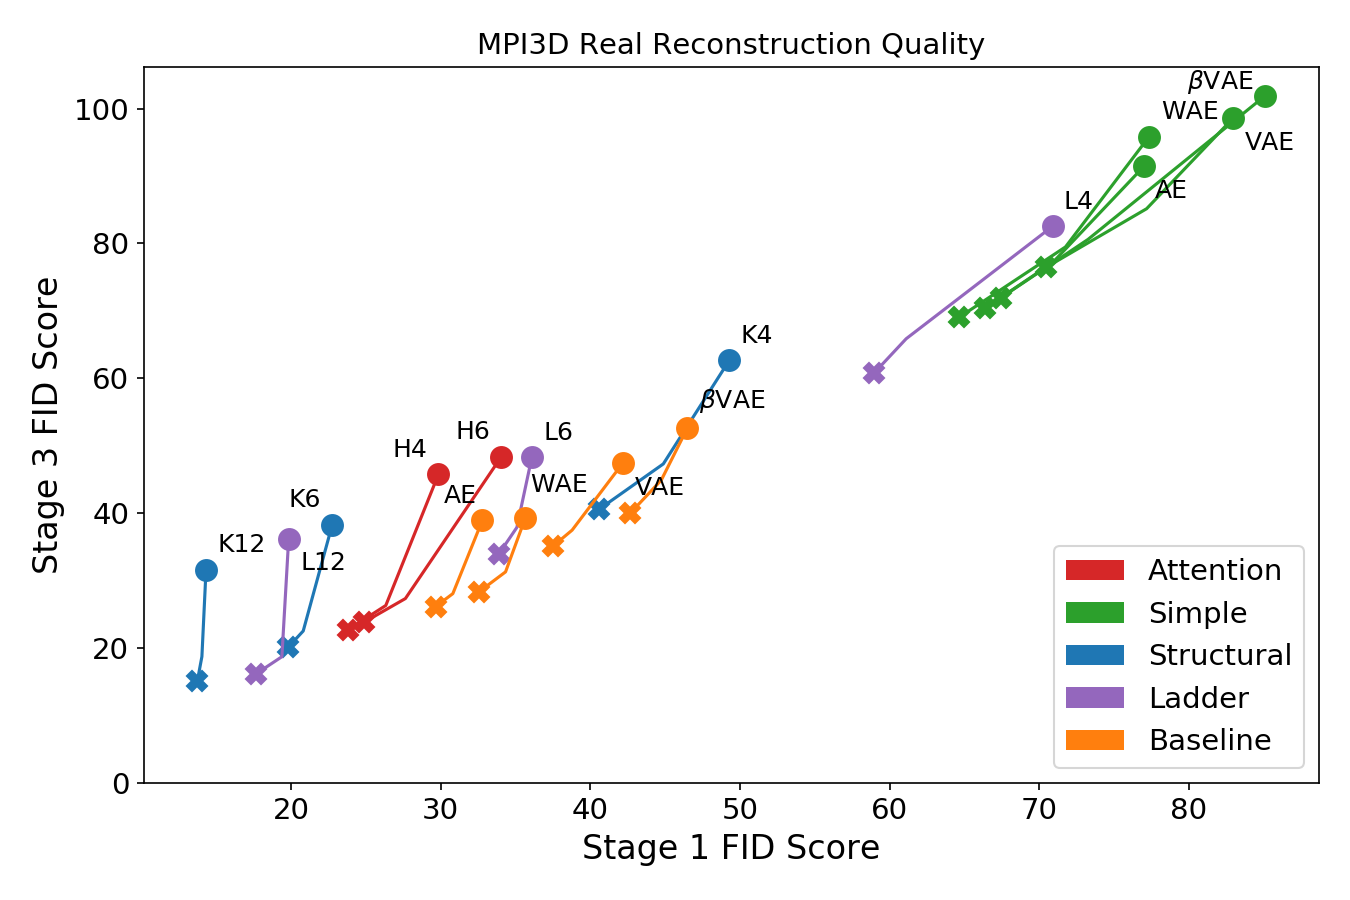

In [59]:
fig, ax = plt.subplots(figsize=fsize)
texts = []
objs = []
tps = set()
ms = 10
# df = [(0,0),(0,-5),(5,0),(-4,0)]
for r, in zip(runs):
    c = colors[r.arch]
    x,y =[],[]
    for i in range(3):
        if f'fid{i+1}' in r:
            x.append(r[f'fid{i+1}'].train)
            y.append(r[f'fid{i+1}'].test)
        else:
            break
    if len(x) < 3:
        continue
    plt.plot(x,y, c=c , ls='-', marker='', )
#     objs.extend(plt.plot(x,y, c=c , ls='-', marker='', ))#size=[8,16])
    objs.extend(plt.plot(x[:1],y[:1], c=c, ls='-', marker='o', markersize=ms))#size=[8,16])
    objs.extend(plt.plot(x[-1:],y[-1:], c=c, marker='X', markersize=ms))#size=[8,16])
    texts.append(plt.text(x[0], y[0], r.name, fontsize=12, horizontalalignment='center',
      verticalalignment='center',))
    tps.add(r.arch)

legend_elements = [Patch(facecolor=colors[name], label=tnames[name]) for name in tps]

    
# legend_elements = [Patch(facecolor='C2', label='Before Update'),
#                   Patch(facecolor='C1', label='After Update')]
plt.legend(handles=legend_elements, loc=4)
plt.xlabel('Stage 1 FID Score')
plt.ylabel('Stage 3 FID Score')
plt.title(f'{ds} Reconstruction Quality')
# plt.xlim(left=6370)
plt.ylim(bottom=0)
# legend_elements = [Patch(facecolor=colors[name], label=tnames[name]) for name in tps]
# plt.legend(handles=legend_elements)
plt.tight_layout()
adjust_text(texts, add_objects=objs, #force_text=(0.1,0.1)
            #force_text=(0.1,0.25),
            force_objects=(0.1,0.1),
           )
pass

In [60]:
save_fig('{}_transfer_test_attn_l'.format(ds.replace(' ','_')))

MPI3D_Real_transfer_test_attn_l saved


<IPython.core.display.Javascript object>


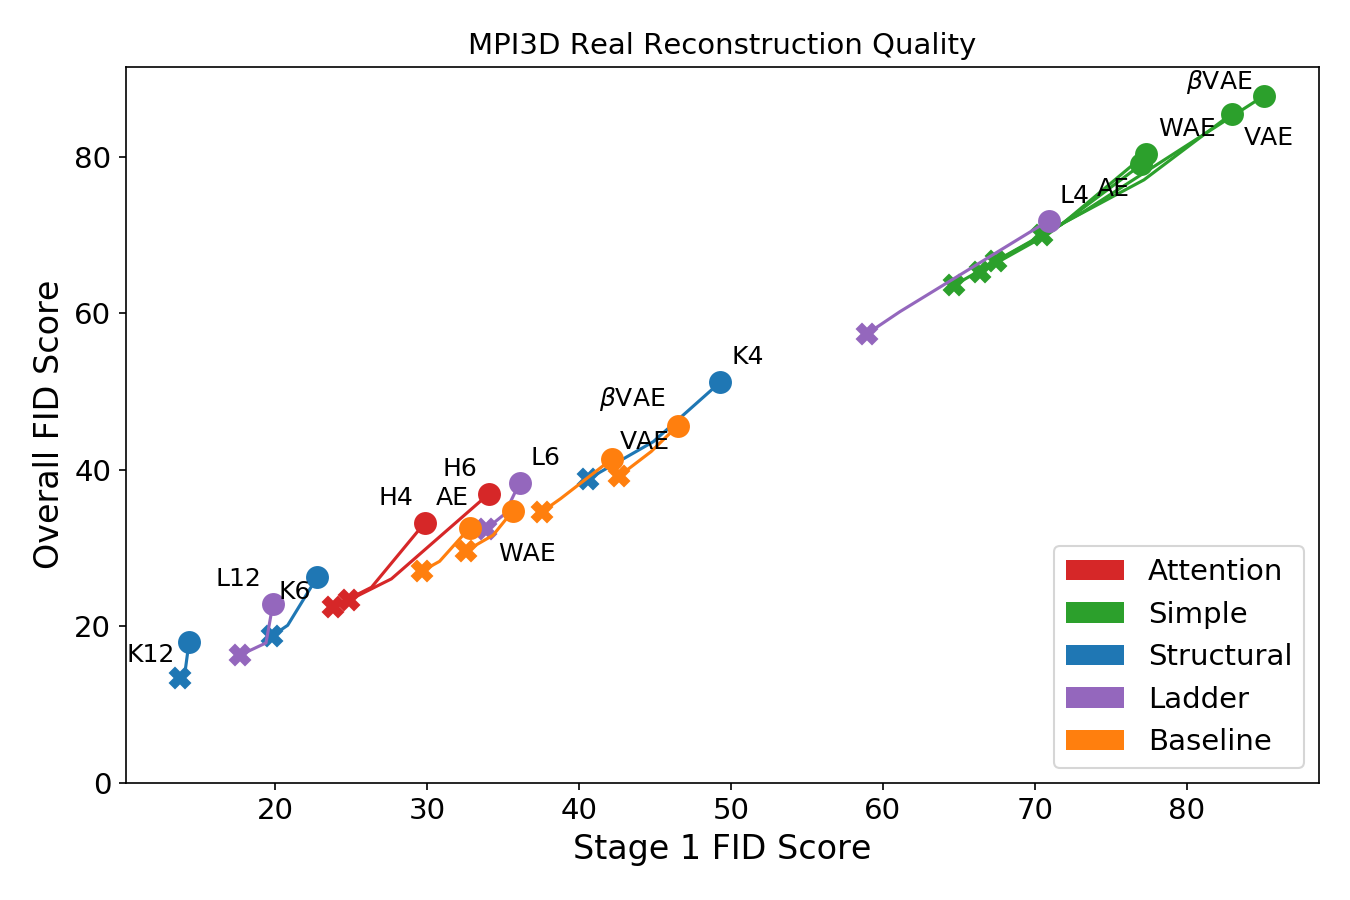

In [61]:
fig, ax = plt.subplots(figsize=fsize)
texts = []
objs = []
tps = set()
ms = 10
# df = [(0,0),(0,-5),(5,0),(-4,0)]
for r, in zip(runs):
    c = colors[r.arch]
    x,y =[],[]
    for i in range(3):
        if f'fid{i+1}' in r:
            x.append(r[f'fid{i+1}'].train)
            y.append(r[f'fid{i+1}'].full)
        else:
            break
    if len(x) < 3:
        continue
    plt.plot(x,y, c=c , ls='-', marker='', )
#     objs.extend(plt.plot(x,y, c=c , ls='-', marker='', ))#size=[8,16])
    objs.extend(plt.plot(x[:1],y[:1], c=c, ls='-', marker='o', markersize=ms))#size=[8,16])
    objs.extend(plt.plot(x[-1:],y[-1:], c=c, marker='X', markersize=ms))#size=[8,16])
    texts.append(plt.text(x[0], y[0], r.name, fontsize=12,horizontalalignment='center',
      verticalalignment='center',))
    tps.add(r.arch)

legend_elements = [Patch(facecolor=colors[name], label=tnames[name]) for name in tps]

    
# legend_elements = [Patch(facecolor='C2', label='Before Update'),
#                   Patch(facecolor='C1', label='After Update')]
plt.legend(handles=legend_elements, loc=4)
plt.xlabel('Stage 1 FID Score')
plt.ylabel('Overall FID Score')
plt.title(f'{ds} Reconstruction Quality')
# plt.xlim(left=6370)
plt.ylim(bottom=0)
# legend_elements = [Patch(facecolor=colors[name], label=tnames[name]) for name in tps]
# plt.legend(handles=legend_elements)
plt.tight_layout()
adjust_text(texts, add_objects=objs, #force_text=(0.1,0.1)
            #force_text=(0.1,0.25),
            force_objects=(0.1,0.1),
           )
pass

In [62]:
save_fig('{}_transfer_overall_attn_l'.format(ds.replace(' ','_')))

MPI3D_Real_transfer_overall_attn_l saved
